### MaxFuse running on 10x pbmc dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import anndata as ad
import scanpy as sc

import sys
sys.path.append("../../MaxFuse_devo/09302022V/")
import match
import metrics
from scipy.io import mmread
import os

In [2]:
meta_rna = pd.read_csv('/atac_bench_nrz/10xpbmc/data/10x_pbmc_meta.csv')
celltype_labels_rna = meta_rna['celltype'].to_numpy()
np.unique(celltype_labels_rna)

array(['CD14 Mono', 'CD16 Mono', 'CD4 Naive', 'CD4 TCM', 'CD8 Naive',
       'CD8 TEM_1', 'CD8 TEM_2', 'Intermediate B', 'MAIT', 'Memory B',
       'NK', 'Naive B', 'Treg', 'cDC', 'pDC'], dtype=object)

In [3]:
# read in the counts
rna = mmread("/atac_bench_nrz/10xpbmc/data/10x_pbmc_rna.txt").tocsr()
rna.shape

(7790, 23146)

In [4]:
# read in the names
rna_names = pd.read_csv(
    '/atac_bench_nrz/10xpbmc/data/10x_pbmc_rna_names.csv'
)['names'].to_numpy()

In [5]:
atacactivity=mmread("/atac_bench_nrz/10xpbmc/data/10x_pbmc_GAS.txt").tocsr()
atacactivity.shape

(7790, 19891)

In [6]:
# activity names
gas_names = pd.read_csv(
    '/atac_bench_nrz/10xpbmc/data/10x_pbmc_GAS_names.csv'
)['names'].to_numpy()

In [7]:
peak_lsi = pd.read_csv('/atac_bench_nrz/10xpbmc/data/10x_pbmc_LSI49.csv')
peak_lsi = peak_lsi.drop('Unnamed: 0', axis=1)
peak_lsi.shape

(7790, 49)

In [23]:
## make rna anndata
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names
rna_adata.obs_names = meta_rna['Unnamed: 0']
rna_adata

AnnData object with n_obs × n_vars = 7790 × 23146

In [24]:
## make GAS anndata
activity_adata = ad.AnnData(atacactivity, dtype=np.float32)
activity_adata.var_names = gas_names
activity_adata

AnnData object with n_obs × n_vars = 7790 × 19891

In [25]:
peak_adata=ad.AnnData(peak_lsi, dtype=np.float32)
peak_adata

/home/bkzhu/python/miniconda3/envs/super_mario_testing/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 7790 × 49

In [26]:
shared_genes = np.intersect1d(rna_adata.var_names, activity_adata.var_names)
len(np.intersect1d(rna_adata.var_names, activity_adata.var_names))

15051

In [27]:
rna_shared = rna_adata[:, shared_genes].X.todense()
activity_shared = activity_adata[:, shared_genes].X.todense()

mask = ((rna_shared.std(axis=0) > 0.01) & (activity_shared.std(axis=0) > 0.01)).A1 # filter out static ones
rna_shared = rna_shared[:, mask]
activity_shared = activity_shared[:, mask]

In [28]:
# input as sct norm so norm can be skipped
rna_shared = ad.AnnData(rna_shared)
#sc.pp.normalize_total(rna_shared) # input data is already normalized
#sc.pp.log1p(rna_shared)
sc.pp.highly_variable_genes(rna_shared, n_top_genes = 3000)
sc.pp.scale(rna_shared)
#rna_shared = rna_shared.X

## atac shared
activity_shared = ad.AnnData(activity_shared)
sc.pp.normalize_total(activity_shared)
sc.pp.log1p(activity_shared)
sc.pp.scale(activity_shared)
#activity_shared = activity_shared.X

In [29]:
vgenes = rna_shared.var.highly_variable

In [30]:
# shared features
rnaC_shared = rna_shared[:,vgenes].X
atac_shared = activity_shared[:,vgenes].X
# all features
rnaC_active = rna_shared[:,vgenes].X
atac_active = peak_adata.X

In [31]:
spm = match.MaxFuse(
        shared_arr1=rnaC_shared,
        shared_arr2=atac_shared,
        active_arr1=rnaC_active,
        active_arr2=atac_active,
        method='centroid_shrinkage',
        labels1=None, # if None, then use scanpy clustering pipeline
        labels2=None
    )

In [32]:
spm.split_into_batches(
        max_outward_size=5000,
        matching_ratio=5,
        metacell_size=2,
        method='binning',
        verbose=True,
        seed=42
    )

The first data is split into 2 batches, average batch size is 3895, and max batch size is 3895.
The second data is split into 1 batches, average batch size is 7790, and max batch size is 7790.
Batch to batch correspondence is:
  ['0<->0', '1<->0'].


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f56e112de50>)

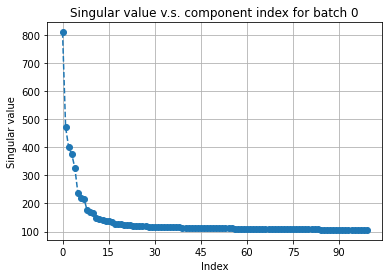

In [33]:
spm.plot_singular_values(
    target='active_arr1',
    batch=0,
    n_components=None,
    randomized_svd=False,  # @Shuxiao: Had to change this from True to False.  Doesn't work when true, why?
    svd_runs=1
)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5640b08e20>)

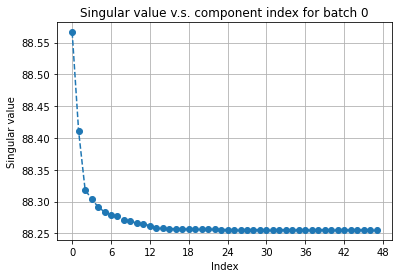

In [34]:
spm.plot_singular_values(
    target='active_arr2',
    batch=0,
    n_components=None,
    randomized_svd=False,  # @Shuxiao: Had to change this from True to False.  Doesn't work when true, why?
    svd_runs=1
)

In [35]:
spm.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=30,
    svd_components2=15,
    resolution1=2,
    resolution2=2,
    randomized_svd=False,  # @Shuxiao: Had to change this from True to False.  Doesn't work when true, why?
    svd_runs=1,
    resolution_tol=0.1,
    leiden_runs=1,
    leiden_seed=None,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Now at batch 1...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Now at batch 1...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


In [36]:
spm.find_initial_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=20, svd_components2=20,
    randomized_svd=False, svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Done!


In [37]:
# test accuracy of initial matching
import utils, metrics
matching = spm._init_matching[0]
labels1 = utils.summarize_clustering(spm._metacell_labels1[0], celltype_labels_rna[spm._batch_to_indices1[0]])
# labels1 = celltype_labels_rna[spm._batch_to_indices1[0]]
labels2 = celltype_labels_rna[spm._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)
# repeat norm 3k --> 91.5
# norep norm 3k --> 90.4

0.903954802259887

In [38]:
spm.refine_pivots(
    wt1=0.7, wt2=0.7,
    svd_components1=200, svd_components2=None,
    cca_components=20,
    filter_prop=0.,
    n_iters=8,
    randomized_svd=False, 
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Done!


In [39]:
# test accuracy of refined matching
matching = spm._refined_matching[0]
labels1 = utils.summarize_clustering(spm._metacell_labels1[0], celltype_labels_rna[spm._batch_to_indices1[0]])
# labels1 = celltype_labels_rna[spm._batch_to_indices1[0]]
labels2 = celltype_labels_rna[spm._batch_to_indices2[0]]
metrics.get_matching_acc(matching, labels1, labels2)

0.9440164355418593

In [40]:
spm.filter_bad_matches(target='pivot', filter_prop=0.4, verbose=True)

Begin filtering...
Now at batch 0<->0...
Now at batch 1<->0...
2336/3894 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
4671/7790 cells in arr1 are selected as pivots.
1974/7790 cells in arr2 are selected as pivots.
Done!


In [50]:
spm.propagate(
    wt1=0.7,
    wt2=0.7,
    svd_components1=30, 
    svd_components2=None, 
    randomized_svd=False, 
    svd_runs=1, 
    verbose=True
)

Now at batch 0<->0...
Now at batch 1<->0...
Done!


In [51]:
spm.filter_bad_matches(
        target='propagated',
        filter_prop=0.,
        verbose=True
    )

Begin filtering...
Now at batch 0<->0...
Now at batch 1<->0...
14802/14802 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [52]:
matching = spm.get_matching(order=(2, 1), target='full_data')
metrics.get_matching_acc(matching, celltype_labels_rna, celltype_labels_rna, order=(2, 1))
# rep3k -> 92.77

0.9215661103979461

In [53]:
full = pd.DataFrame(list(zip(matching[0],matching[1],matching[2])), columns = ["idx1","idx2","score"])
full.to_csv("/atac_bench_nrz/10xpbmc/mf/full_idx_21.csv", index=False)

In [54]:
arr1_cca, arr2_cca = spm.get_embedding(
        active_arr1 = spm.active_arr1,
        active_arr2 = spm.active_arr2,
        refit=False,
        matching=None,
        order=None,
        cca_components=20,
        cca_max_iter=None
    )

In [55]:
out_idx = 20 # used 15 in downstream analysis
arr1_df = pd.DataFrame(arr1_cca).iloc[:,0:out_idx]
arr2_df = pd.DataFrame(arr2_cca).iloc[:,0:out_idx]
arr1_df.to_csv("/atac_bench_nrz/10xpbmc/mf/full_embed_x0.csv",index=False)
arr2_df.to_csv("/atac_bench_nrz/10xpbmc/mf/full_embed_y0.csv", index=False)